# Classification of earthquakes signals using unsupervised outlier detections

Dataset: http://www.timeseriesclassification.com/description.php?Dataset=Earthquakes

We have two classes: normal and abnormal. We perform the feature engineering as follows:
<li> We extract the features using the package, tsfel.
<li> We then perform the oversampling for the imbalanced dataset. 
<br>
We adopt the methods of unsupervised outlier detection for classification. The methods are provided as follows:
<li> OneClassSVM
<li> IsolationForest
<li> EllipticEnvelope
<li> LocalOutlierFactor
<br>
<br>
We compare the performance of those methods.

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
from time import time
import tsfel
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, jaccard_score 
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Load the data

In [2]:
train = arff.loadarff('Earthquakes_TRAIN.arff')
test = arff.loadarff('Earthquakes_TEST.arff')

In [3]:
train = pd.DataFrame(train[0])
test = pd.DataFrame(test[0])

We have two classes: 0 (negative) and 1 (positive).

In [4]:
train.target.value_counts()

b'0'    264
b'1'     58
Name: target, dtype: int64

The data is imbalanced.

We plot the two time-series from the two classes.

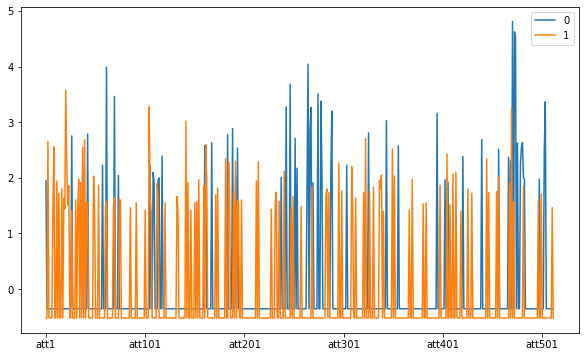

In [5]:
temp = pd.concat([train[train.target==b'0'].iloc[0,:-1], train[train.target==b'1'].iloc[0,:-1]], axis=1)
temp.columns = ['0', '1']
temp.plot(figsize=(10,6))
plt.show()

In [6]:
train = train.sample(frac=1).reset_index(drop=True) # Shuffle the sample

In [7]:
def split_data(data, split=0.1):
    split_index = int(len(data)*split)
    train = data[split_index:]
    test = data[:split_index]
    return train, test

Split the data into train and validation datasets

In [8]:
train, val = split_data(train)

This validation dataset can be used to tune the model.

Label the data as 0 and 1

In [9]:
le = LabelEncoder()
train_y = le.fit_transform(train.iloc[:,-1])
val_y = le.fit_transform(val.iloc[:,-1])
test_y = le.fit_transform(test.iloc[:,-1])

In [10]:
values, counts = np.unique(val_y, return_counts=True)
print("Labels: ", dict(zip(values, counts)))

Labels:  {0: 27, 1: 5}


# Feature extraction using tsfel

In [11]:
# Parameters
fs = 100

window = None

verbose = 0

In [12]:
cfg_file = tsfel.get_features_by_domain() 

In [13]:
def ts_featureextract(data, cfg_file, fs, window, verbose):
    size = len(data.columns)
    temp = pd.DataFrame()
    for i in range(size):
        extract = tsfel.time_series_features_extractor(cfg_file, data.iloc[:,i], 
                                                       fs=fs, window_size=window, 
                                                       verbose=verbose)
        extract = pd.DataFrame(extract.values.reshape(1,-1))
        temp = pd.concat([temp, extract], axis=0)

    return temp.values

In [14]:
temp = train[train.target==b'0'].iloc[:,:-1].reset_index(drop=True).T
train_X = ts_featureextract(temp, cfg_file, fs, window, verbose)

In [15]:
temp = val.iloc[:,:-1].reset_index(drop=True).T
val_X = ts_featureextract(temp, cfg_file, fs, window, verbose)

In [16]:
temp = test.iloc[:,:-1].reset_index(drop=True).T
test_X = ts_featureextract(temp, cfg_file, fs, window, verbose)

In [17]:
def classification_metrics(truedata, pred):
    print("Metrics")
    print("=======================")
    tn, fp, fn, tp = confusion_matrix(truedata, pred).ravel()
    print("True positive: ", tp)
    print("True negative: ", tn)
    print("False positive: ", fp)
    print("False negative: ", fn)
    print()
    acc = accuracy_score(truedata, pred)
    f1 = f1_score(truedata, pred)
    jaccard = jaccard_score(truedata, pred)
    sensitivity = tp / (tp + fn)
    specificity = tn / (fp + tn)
    gmean = np.sqrt(sensitivity*specificity)
    print("Accuracy: ", round(acc,3))
    print("F1 score: ", round(f1,3))
    print("Jaccard Score: ", round(jaccard,3))
    print("G-Mean: ", round(gmean,3))
    return [acc, f1, jaccard, gmean]

In [18]:
def label_conversion(pred):
    # We convert 1 (inliers) as 0 and -1 (outliers) as 1
    # for the labels
    index = np.where(pred==1)
    pred[index] = 0
    index = np.where(pred==-1)
    pred[index] = 1
    return pred

Scale the data for training models

In [19]:
scaler = StandardScaler()

In [20]:
scaled_train_X = scaler.fit_transform(train_X)
scaled_val_X = scaler.transform(val_X)
scaled_test_X = scaler.transform(test_X)

# OneClassSVM

In [21]:
def tune_OneClassSVM(train_X, val_X, val_y, parm_list):
    max = -1
    opt_parm = 0
    for parm in parm_list:
        model = OneClassSVM(degree=5, nu=parm, tol=1e-6)
        model.fit(train_X)
        pred = model.predict(val_X)
        pred = label_conversion(pred)
        
        score = f1_score(val_y, pred)
        if max <= score:
            max = score
            opt_parm = parm
    print("Max. score is ", round(max,3))
    print("Optimal parameter is ", round(opt_parm,3))
    
    # Best model with optimal parmater
    model = OneClassSVM(degree=3, nu=opt_parm, tol=1e-6)
    model.fit(train_X)
    return model

In [22]:
parm_list = list(np.arange(.10,1,.05))

In [23]:
model = tune_OneClassSVM(scaled_train_X, scaled_val_X, val_y, parm_list)

Max. score is  0.375
Optimal parameter is  0.15


In [24]:
pred = model.predict(scaled_test_X)
pred = label_conversion(pred)

column = ['Accuracy', 'F1 Score', 'Jaccard Score', 'G-Mean']
metrics = pd.DataFrame(columns=column)

temp = pd.DataFrame(classification_metrics(test_y, pred)).T
temp.columns = column
metrics = pd.concat([metrics, temp], axis=0)

metrics_index = []
metrics_index.append('OneClassSVM')

Metrics
True positive:  11
True negative:  65
False positive:  39
False negative:  24

Accuracy:  0.547
F1 score:  0.259
Jaccard Score:  0.149
G-Mean:  0.443


# IsolationForest

In [25]:
parm_list = list(np.arange(2,100,5))

In [26]:
contamination = train.target.value_counts().values[1]/train.target.value_counts().values[0]

In [27]:
def tune_IsolationForest(train_X, val_X, val_y, parm_list, contamination):
    max = -1
    opt_parm = 0
    for parm in parm_list:
        model = IsolationForest(n_estimators=int(parm), contamination=contamination)
        model.fit(train_X)
        pred = model.predict(val_X)
        pred = label_conversion(pred)
        
        score = f1_score(val_y, pred)
        if max <= score:
            max = score
            opt_parm = parm
    print("Max. score is ", round(max,3))
    print("Optimal parameter is ", opt_parm)
    
    # Best model with optimal parmater
    model = IsolationForest(n_estimators=int(opt_parm), contamination=contamination)
    model.fit(train_X)
    return model

In [28]:
model = tune_IsolationForest(scaled_train_X, scaled_val_X, val_y, parm_list, contamination)

Max. score is  0.444
Optimal parameter is  32


In [29]:
pred = model.predict(scaled_test_X)
pred = label_conversion(pred)

temp = pd.DataFrame(classification_metrics(test_y, pred)).T
temp.columns = column
metrics = pd.concat([metrics, temp], axis=0)

metrics_index.append('IsolationForest')

Metrics
True positive:  9
True negative:  70
False positive:  34
False negative:  26

Accuracy:  0.568
F1 score:  0.231
Jaccard Score:  0.13
G-Mean:  0.416


# EllipticEnvelope

In [30]:
parm_list = list(np.arange(0.05,1,.05))

In [31]:
def tune_EllipticEnvelope(train_X, val_X, val_y, parm_list, contamination):
    max = -1
    opt_parm = 0
    for parm in parm_list:
        model = EllipticEnvelope(support_fraction=parm, contamination=contamination)
        model.fit(train_X)
        pred = model.predict(val_X)
        pred = label_conversion(pred)
        
        score = f1_score(val_y, pred)
        if max <= score:
            max = score
            opt_parm = parm
    print("Max. score is ", round(max,3))
    print("Optimal parameter is ", opt_parm)
    
    # Best model with optimal parmater
    model = EllipticEnvelope(support_fraction=opt_parm, contamination=contamination)
    model.fit(train_X)
    return model

In [32]:
model = tune_EllipticEnvelope(scaled_train_X, scaled_val_X, val_y, parm_list, contamination)

Max. score is  0.545
Optimal parameter is  0.4


In [33]:
pred = model.predict(scaled_test_X)
pred = label_conversion(pred)

temp = pd.DataFrame(classification_metrics(test_y, pred)).T
temp.columns = column
metrics = pd.concat([metrics, temp], axis=0)

metrics_index.append('EllipticEnvelope')

Metrics
True positive:  7
True negative:  70
False positive:  34
False negative:  28

Accuracy:  0.554
F1 score:  0.184
Jaccard Score:  0.101
G-Mean:  0.367


# LocalOutlierFactor

In [34]:
parm_list = list(np.arange(2,40,1))

In [35]:
def tune_LocalOutlierFactor(train_X, val_X, val_y, parm_list):
    max = -1
    opt_parm = 0
    for parm in parm_list:
        model = LocalOutlierFactor(n_neighbors=int(parm), novelty=True, algorithm='ball_tree',leaf_size=10)
        model.fit(train_X)
        pred = model.predict(val_X)
        pred = label_conversion(pred)
        
        score = f1_score(val_y, pred)
        if max <= score:
            max = score
            opt_parm = parm
    print("Max. score is ", round(max,3))
    print("Optimal parameter is ", opt_parm)
    
    # Best model with optimal parmater
    model = LocalOutlierFactor(n_neighbors=opt_parm, novelty=True, algorithm='kd_tree')
    model.fit(train_X)
    return model

In [36]:
model = tune_LocalOutlierFactor(scaled_train_X, scaled_val_X, val_y, parm_list)

Max. score is  0.0
Optimal parameter is  39


In [37]:
pred = model.predict(scaled_test_X)
pred = label_conversion(pred)

temp = pd.DataFrame(classification_metrics(test_y, pred)).T
temp.columns = column
metrics = pd.concat([metrics, temp], axis=0)

metrics_index.append('LocalOutlierFactor')

Metrics
True positive:  1
True negative:  104
False positive:  0
False negative:  34

Accuracy:  0.755
F1 score:  0.056
Jaccard Score:  0.029
G-Mean:  0.169


# Summary

In [38]:
metrics.index = metrics_index

In [39]:
metrics

,Accuracy,F1 Score,Jaccard Score,G-Mean
OneClassSVM,0.546763,0.258824,0.148649,0.443203
IsolationForest,0.568345,0.230769,0.130435,0.416025
EllipticEnvelope,0.553957,0.184211,0.101449,0.366900
LocalOutlierFactor,0.755396,0.055556,0.028571,0.169031


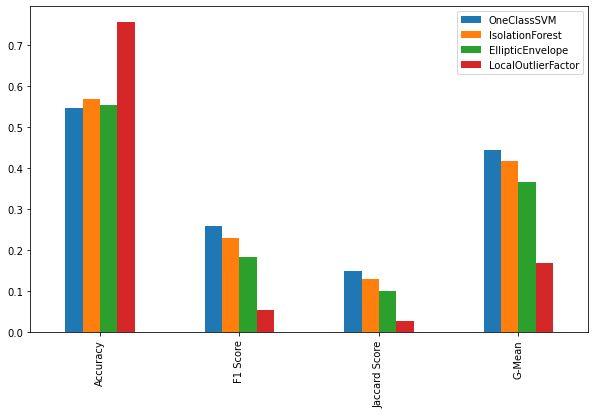

In [40]:
metrics.T.plot(kind='bar', figsize=(10,6))
plt.show()

<li> OneClassSVM can give the highest F1 score, Jaccard score and G-Mean. The second best is IsolationForest.
<li> The metrics, accuracy, is not a good measure for imbalanced data. For example, LocalOutlierFactor is poor to predict true positive but its accuracy is high.